In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

#Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

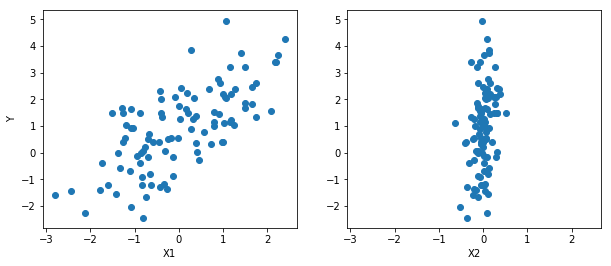

In [8]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

In [9]:
from pymc3 import Model, Normal, HalfNormal
from pymc3 import find_MAP

with Model() as basic_model:
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    #  Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
    
    map_estimate = find_MAP(model=basic_model)
    print map_estimate
    

Optimization terminated successfully.
         Current function value: 149.017982
         Iterations: 16
         Function evaluations: 21
         Gradient evaluations: 21
{'alpha': array(0.9065985497559482), 'beta': array([ 0.94848602,  2.60705514]), 'sigma_log_': array(-0.032781470174030714)}


In [10]:
try:
    from pandas_datareader import data
except ImportError:
    !pip install pandas-datareader
    from pandas_datareader import data

In [11]:
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')\
['Adj Close'].pct_change()

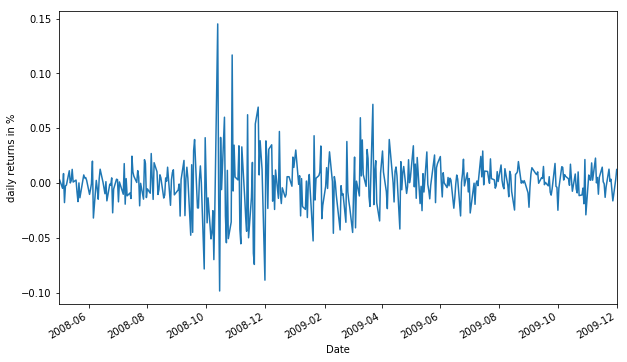

In [12]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %')

In [15]:
from pymc3 import Exponential, StudentT, Deterministic
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

with Model() as sp500_model:
    
    nu = Exponential('nu', 1./10, testval=5.)
    sigma = Exponential('sigma', 1./.02, testval=.1)
    
    s = GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    
    volatility_process = Deterministic('volatility_process', exp(-2*s))
    
    r = StudentT('r', nu, lam=1/volatility_process, observed=returns)

# Fitting

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.46: 100%|██████████| 200000/200000 [00:44<00:00, 4459.39it/s]
Finished [100%]: Average ELBO = 883.4
100%|██████████| 2000/2000 [03:09<00:00, 10.54it/s]


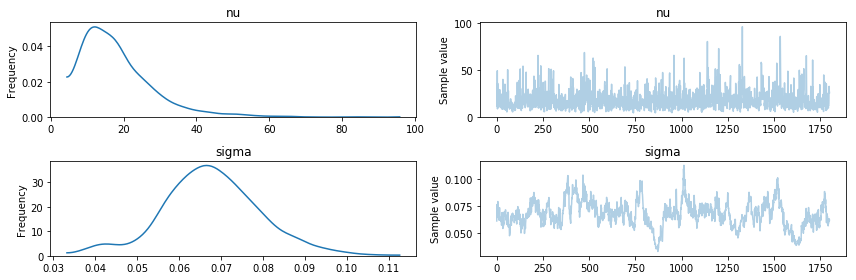

In [18]:
from pymc3 import variational
from pymc3 import sample, traceplot

with sp500_model:
    trace = sample(2000)
    traceplot(trace[200:], [nu, sigma])


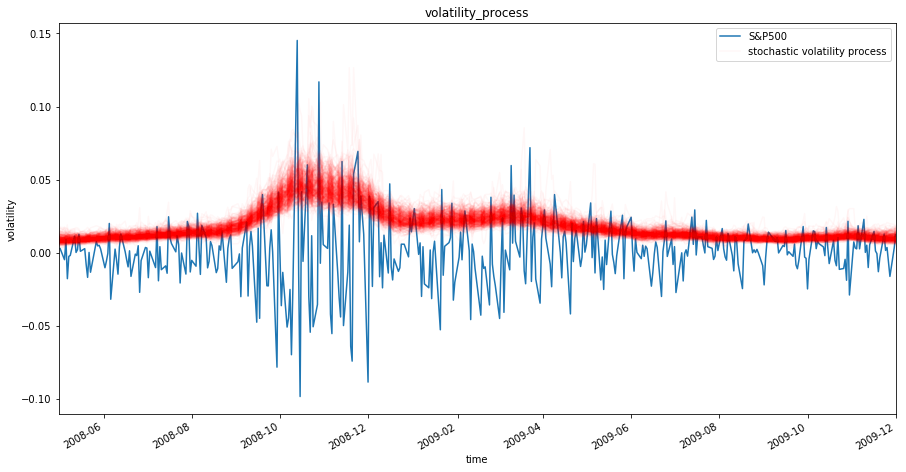

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))

returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace[s, ::5].T), 'r', alpha=.03)
ax.set(title='volatility_process', xlabel='time', ylabel='volatility')
ax.legend(['S&P500', 'stochastic volatility process'])

# Case study 2: Coal mining disasters

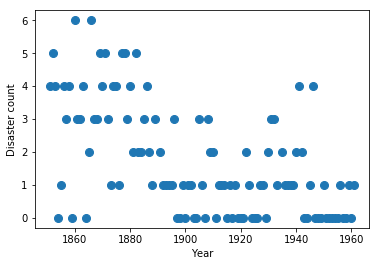

In [20]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8)
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [23]:
from pymc3 import DiscreteUniform, Poisson
from pymc3.math import switch

with Model() as disaster_model:
    switch_point = DiscreteUniform('switchpoint', 
                                   lower=year.min(),
                                   upper=year.max())
    early_rate = Exponential('early_rate', 1)
    late_rate = Exponential('late_rate', 1)
    
    rate = switch(switch_point >=year , early_rate, late_rate)
    disasters = Poisson('disasters', rate, observed=disaster_data)
    
    trace = sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log_
Assigned NUTS to late_rate_log_
Assigned Metropolis to disasters_missing
100%|██████████| 10000/10000 [00:21<00:00, 464.11it/s]


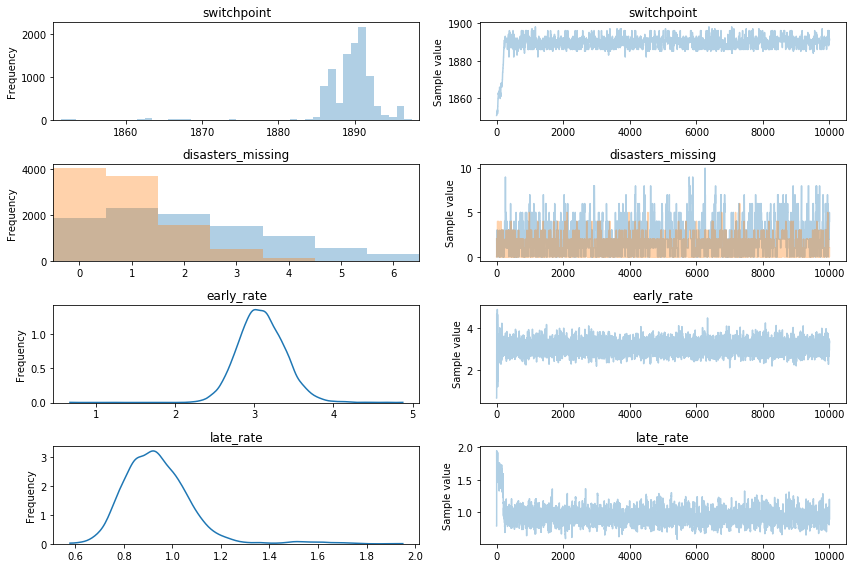

In [24]:
with disaster_model:
    traceplot(trace);